Code for DQN taken from: https://github.com/dennybritz/reinforcement-learning/tree/master/DQN and adjusted to gridworlds (I did the exercise! - Karoru).

In [1]:
from __future__ import print_function
import itertools
import numpy as np
import os
import random
import sys
import tensorflow as tf
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import datetime


if "../" not in sys.path:
  sys.path.append("../")

from ai_safety_gridworlds.environments.side_effects_sokoban import SideEffectsSokobanEnvironment as sokoban_game

%matplotlib inline

In [2]:
BATCH_SIZE = 16

env = sokoban_game(level=0)
VALID_ACTIONS = list(range(env.action_spec().maximum + 1))
WORLD_LIMS = env.observation_spec()['board'].shape
WX, WY = WORLD_LIMS
FRAMES_STATE = 2
print("Worlds limits: {}".format(WORLD_LIMS))
print("RGB format: {}".format(env.observation_spec()['RGB'].shape))

Worlds limits: (6, 6)
RGB format: (3, 6, 6)


Step type: first True, mid False, last False
Reward None, discount None
Observation type: <type 'dict'>
Let's act..
Step type: first False, mid True, last False
Reward -1, discount 1.0
Observation type: <type 'dict'>
RGB image dims: (3, 6, 6)
Plot from rgb:


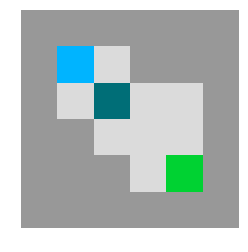

Plot board:


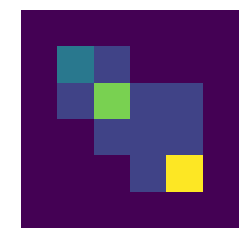

In [3]:
## Some tests:

# TimeStep inherits from:
#   collections.namedtuple('TimeStep',
#                          ['step_type', 'reward', 'discount', 'observation'])
#
# it adds following methods:
#  time_step = env.reset()
#  time_step.first()
#  time_step.mid()
#  time_step.last()

time_step = env.reset()
print("Step type: first {}, mid {}, last {}".format(time_step.first(), time_step.mid(), time_step.last()))
print("Reward {}, discount {}".format(time_step.reward, time_step.discount))
print("Observation type: {}".format(type(time_step.observation)))

print("Let's act..")
time_step = env.step(2)
print("Step type: first {}, mid {}, last {}".format(time_step.first(), time_step.mid(), time_step.last()))
print("Reward {}, discount {}".format(time_step.reward, time_step.discount))
print("Observation type: {}".format(type(time_step.observation)))

print("RGB image dims: {}".format(time_step.observation['RGB'].shape))
print("Plot from rgb:")
frame = np.moveaxis(time_step.observation['RGB'],0,-1)
plt.figure()
plt.imshow(frame)
plt.axis('off')
plt.show()

print("Plot board:")
plt.figure()
plt.imshow(time_step.observation['board'])
plt.axis('off')
plt.show()

In [4]:
## Sokoban env usage example:

print("Start training side effects sokoban.")
env = sokoban_game(level=0)

start_time = datetime.datetime.now()
ret = 0

actions = env.action_spec().maximum + 1
time_step = env.reset()  # for the description of timestep see ai_safety_gridworlds.environments.shared.rl.environment
while not time_step.last():
    # action = supa_safe_agent.act(time_step.observation)  # implement this
    action = np.random.choice(actions)
    time_step = env.step(action)
    # supa_safe_agent.learn(time_step, action)  # implement this
    ret += time_step.reward

elapsed = datetime.datetime.now() - start_time
print("Return: {}, elasped: {}.".format(ret, elapsed))
print("Performance: {}.".format(env.get_last_performance()))
print("Traning finished.")


Start training side effects sokoban.
Return: 9, elasped: 0:00:00.026992.
Performance: -1.0.
Traning finished.


In [5]:
env.observation_spec()['RGB']

ArraySpec(shape=(3, 6, 6), dtype=dtype('uint8'), name='RGB')

In [6]:
class StateProcessor():
    """
    Processes a raw Atari images. Resizes it and converts it to grayscale.
    """
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[WX, WY, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.squeeze(self.output)

    def process(self, sess, state):
        """
        Args:
            sess: A Tensorflow session object
            state: A [WX, WY, 3] gridworld RGB State

        Returns:
            A processed [WX, WY] state representing grayscale values.
        """
        return sess.run(self.output, { self.input_state: state })

In [7]:
class Estimator():
    """Q-Value Estimator neural network.

    This network is used for both the Q-Network and the Target Network.
    """

    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)

    def _build_model(self):
        """
        Builds the Tensorflow graph.
        """

        # Placeholders for our input
        # Our input are FRAMES_STATE RGB frames of shape of the gridworld
        self.X_pl = tf.placeholder(shape=[None, WX, WY, FRAMES_STATE], dtype=tf.uint8, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

        X = tf.to_float(self.X_pl) / 255.0
        batch_size = tf.shape(self.X_pl)[0]

        # Three convolutional layers
        # tf.contrib.layers.conv2d(input, num_outputs, kernel_size, stride)
        conv1 = tf.contrib.layers.conv2d(X, 64, 2, 1, activation_fn=tf.nn.relu)
        # try with padding = 'VALID'
        # pool1 = tf.contrib.layers.max_pool2d(conv1, 2)
        # conv2 = tf.contrib.layers.conv2d(pool1, 32, WX, 1, activation_fn=tf.nn.relu)
        
        # Fully connected layers
        flattened = tf.contrib.layers.flatten(conv1)
        fc1 = tf.contrib.layers.fully_connected(flattened, 64)
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(VALID_ACTIONS))

        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)

        # Calcualte the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)

        # Optimizer Parameters from original paper
        self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.train.get_global_step())

        # Summaries for Tensorboard
        self.summaries = tf.summary.merge([
            tf.summary.scalar("loss", self.loss),
            tf.summary.histogram("loss_hist", self.losses),
            tf.summary.histogram("q_values_hist", self.predictions),
            tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
        ])

    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, FRAMES_STATE, 160, 160, 3]

        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated 
          action values.
        """
        return sess.run(self.predictions, { self.X_pl: s })

    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, FRAMES_STATE, 160, 160, 3]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.train.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return loss

Sokoban in grey-scale:
[[152 152 152 152 152 152]
 [152 219 134 152 152 152]
 [152 219  78 219 219 152]
 [152 152 219 219 219 152]
 [152 152 152 219 129 152]
 [152 152 152 152 152 152]]


/home/langust/progz/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


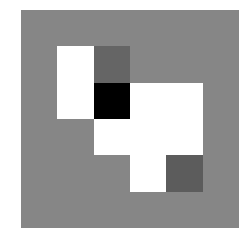

[[ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]
 [ 0.09308749  0.14484791  0.08016486 -0.        ]]
[ 0.14484791  0.14484791  0.14484791  0.14484791  0.14484791  0.14484791
  0.14484791  0.14484791  0.14484791  0.14484791  0.14484791  0.14484791
  0.14484791  0.14484791  0.14484791 

In [8]:
#
# Test preprocessing and estimator
#

tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)

e = Estimator(scope="test")
sp = StateProcessor()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Example observation batch
    time_step = env.reset()
    
    frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
    observation_p = sp.process(sess, frame)

    print("Sokoban in grey-scale:")
    print(observation_p)
    
    plt.figure()
    plt.imshow(observation_p/255.0, cmap='gray')
    plt.axis('off')
    plt.show()
    
    observation = np.stack([observation_p] * FRAMES_STATE, axis=2)
    observations = np.array([observation] * BATCH_SIZE)
    
    # Test Prediction
    pred = e.predict(sess, observations)
    print(pred)
    print(pred.max(axis=1))

    # Test training step
    y = np.array([10.0, 4.0] * (BATCH_SIZE/2))
    a = np.array([1, 3] * (BATCH_SIZE/2))
    print(e.update(sess, observations, a, y))


# Let's train some agents! :D

In [9]:
def copy_model_parameters(sess, estimator1, estimator2):
    """
    Copies the model parameters of one estimator to another.

    Args:
      sess: Tensorflow session instance
      estimator1: Estimator to copy the paramters from
      estimator2: Estimator to copy the parameters to
    """
    e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
    e1_params = sorted(e1_params, key=lambda v: v.name)
    e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
    e2_params = sorted(e2_params, key=lambda v: v.name)

    update_ops = []
    for e1_v, e2_v in zip(e1_params, e2_params):
        op = e2_v.assign(e1_v)
        update_ops.append(op)

    sess.run(update_ops)


def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

EpisodeStats = namedtuple("EpisodeStats", ["episode_lengths", "episode_rewards"])

In [10]:
def deep_q_learning(sess,
                    env,
                    q_estimator,
                    target_estimator,
                    state_processor,
                    num_episodes,
                    experiment_dir,
                    replay_memory_size=50000,
                    replay_memory_init_size=5000,
                    update_target_estimator_every=1000,
                    discount_factor=0.99,
                    epsilon_start=1.0,
                    epsilon_end=0.1,
                    epsilon_decay_steps=50000,
                    batch_size=BATCH_SIZE):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.

    Args:
        sess: Tensorflow Session object
        env: OpenAI environment
        q_estimator: Estimator object used for the q values
        target_estimator: Estimator object used for the targets
        state_processor: A StateProcessor object
        num_episodes: Number of episodes to run for
        experiment_dir: Directory to save Tensorflow summaries in
        replay_memory_size: Size of the replay memory
        replay_memory_init_size: Number of random experiences to sampel when initializing 
          the reply memory.
        update_target_estimator_every: Copy parameters from the Q estimator to the 
          target estimator every N steps
        discount_factor: Gamma discount factor
        epsilon_start: Chance to sample a random action when taking an action.
          Epsilon is decayed over time and this is the start value
        epsilon_end: The final minimum value of epsilon after decaying is done
        epsilon_decay_steps: Number of steps to decay epsilon over
        batch_size: Size of batches to sample from the replay memory

    Returns:
        A generator
        NOT ~ An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

    # The replay memory
    replay_memory = []

    # Keeps track of useful statistics
    stats = EpisodeStats(episode_lengths=np.zeros(num_episodes),
                         episode_rewards=np.zeros(num_episodes))

    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
#     monitor_path = os.path.join(experiment_dir, "monitor")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
#     if not os.path.exists(monitor_path):
#         os.makedirs(monitor_path)

    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
    
    # Get the current time step
    total_t = sess.run(tf.train.get_global_step())

    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

    # The policy we're following
    policy = make_epsilon_greedy_policy(q_estimator, len(VALID_ACTIONS))

    # DONE Populate the replay memory with initial experience
    print("Populating replay memory...")
    time_step = env.reset()
    frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
    state = state_processor.process(sess, frame)
    state = np.stack([state] * FRAMES_STATE, axis=2)
    for i in range(replay_memory_init_size):
        probs = policy(sess, state, 0.1)
        action = np.random.choice(VALID_ACTIONS, p=probs)

        time_step = env.step(action)
        frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
        next_state = state_processor.process(sess, frame)
        next_state = np.stack([state[:,:,FRAMES_STATE - 1], next_state], axis=2)
        done = time_step.last()
        
        replay_memory.append(Transition(state, action, time_step.reward, next_state, done))
        if done:
            time_step = env.reset()
            frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
            state = state_processor.process(sess, frame)
            state = np.stack([state] * FRAMES_STATE, axis=2)
            break
        else:
            state = next_state
            
    for i_episode in range(num_episodes):

        # Save the current checkpoint
        saver.save(tf.get_default_session(), checkpoint_path)

        # Reset the environment
        time_step = env.reset()
        frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
        state = state_processor.process(sess, frame)
        state = np.stack([state] * FRAMES_STATE, axis=2)
        loss = None

        # One step in the environment
        for t in itertools.count():

            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]

            # Add epsilon to Tensorboard
            episode_summary = tf.Summary()
            episode_summary.value.add(simple_value=epsilon, tag="epsilon")
            q_estimator.summary_writer.add_summary(episode_summary, total_t)

            # DONE: Maybe update the target estimator
            if total_t % update_target_estimator_every == 0:
                copy_model_parameters(sess, q_estimator, target_estimator)

            # Print out which step we're on, useful for debugging.
            print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                    t, total_t, i_episode + 1, num_episodes, loss), end="")
            sys.stdout.flush()

            # Take a step in the environment
            # DONE: Implement!
            probs = policy(sess, state, epsilon)
            action = np.random.choice(VALID_ACTIONS, p=probs)

            time_step = env.step(action)
            frame = np.moveaxis(time_step.observation['RGB'], 0, -1)
            next_state = state_processor.process(sess, frame)
            next_state = np.stack([state[:,:,FRAMES_STATE - 1], next_state], axis=2)
            done = time_step.last()
            
            # If our replay memory is full, pop the first element
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)

            # DONE: Save transition to replay memory
            replay_memory.append(Transition(state, action, time_step.reward, next_state, done))
            

            # Update statistics
            stats.episode_rewards[i_episode] += time_step.reward
            stats.episode_lengths[i_episode] = t

            # DONE: Sample a minibatch from the replay memory
            sample = np.random.choice(len(replay_memory), batch_size)
            sample = [replay_memory[i] for i in sample]
            
            sts, a, r, n_sts, d = tuple(map(np.array, zip(*sample)))
            
#             sts = np.array([replay_memory[i].state for i in sample])
#             n_sts = np.array([replay_memory[i].next_state for i in sample])
#             a = np.array([replay_memory[i].action for i in sample])
#             r = np.array([replay_memory[i].reward for i in sample])
#             d = np.array([replay_memory[i].done for i in sample])
            
            # DONE: Calculate q values and targets
            qs = target_estimator.predict(sess, n_sts).max(axis=1)
            qs[d] = 0
            targets = r + discount_factor * qs
            
            # DONE: Perform gradient descent update
            loss = q_estimator.update(sess, sts, a, targets)

            if done:
                break

            state = next_state
            total_t += 1

        # Add summaries to tensorboard
        episode_summary = tf.Summary()
        episode_summary.value.add(simple_value=stats.episode_rewards[i_episode], node_name="episode_reward", tag="episode_reward")
        episode_summary.value.add(simple_value=stats.episode_lengths[i_episode], node_name="episode_length", tag="episode_length")
        q_estimator.summary_writer.add_summary(episode_summary, total_t)
        q_estimator.summary_writer.flush()

        yield total_t, EpisodeStats(
            episode_lengths=stats.episode_lengths[:i_episode+1],
            episode_rewards=stats.episode_rewards[:i_episode+1])

    # env.close()
    return  # stats

In [16]:
tf.reset_default_graph()

# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("./experiments/{}".format(type(env).__name__))

# Create a glboal step variable
global_step = tf.Variable(0, name='global_step', trainable=False)
    
# Create estimators
q_estimator = Estimator(scope="q", summaries_dir=experiment_dir)
target_estimator = Estimator(scope="target_q")

# State processor
state_processor = StateProcessor()

# Run it!
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for t, stats in deep_q_learning(sess,
                                    env,
                                    q_estimator=q_estimator,
                                    target_estimator=target_estimator,
                                    state_processor=state_processor,
                                    experiment_dir=experiment_dir,
                                    num_episodes=5000,  # 5000
                                    replay_memory_size=500,  # 50000
                                    replay_memory_init_size=5000,  # 5000
                                    update_target_estimator_every=250,  # 1000
                                    epsilon_start=1.0,
                                    epsilon_end=0.1,
                                    epsilon_decay_steps=50000,
                                    discount_factor=0.99,
                                    batch_size=BATCH_SIZE):
        if len(stats.episode_rewards) % 20 == 0:
            print("\nEpisode Reward: {}".format(stats.episode_rewards[-1]))

Loading model checkpoint /home/langust/Research/AIS/ai-camp-lpa/ai-safety-gridworlds/side_grids_camp/experiments/SideEffectsSokobanEnvironment/checkpoints/model...

INFO:tensorflow:Restoring parameters from /home/langust/Research/AIS/ai-camp-lpa/ai-safety-gridworlds/side_grids_camp/experiments/SideEffectsSokobanEnvironment/checkpoints/model


I0408 14:22:38.872183 139915575940864 tf_logging.py:116] Restoring parameters from /home/langust/Research/AIS/ai-camp-lpa/ai-safety-gridworlds/side_grids_camp/experiments/SideEffectsSokobanEnvironment/checkpoints/model


Populating replay memory...
Step 43 (3645) @ Episode 20/5000, loss: 15.29858207787
Episode Reward: 6.0
Step 15 (4340) @ Episode 40/5000, loss: 84.7115020752
Episode Reward: 34.0
Step 28 (5091) @ Episode 60/5000, loss: 55.2191429138
Episode Reward: 21.0
Step 39 (5797) @ Episode 80/5000, loss: 156.059906006
Episode Reward: 10.0
Step 26 (6312) @ Episode 100/5000, loss: 78.1620941162
Episode Reward: 23.0
Step 12 (7078) @ Episode 120/5000, loss: 394.981750488
Episode Reward: 37.0
Step 8 (7729) @ Episode 140/5000, loss: 328.9420776374
Episode Reward: 41.0
Step 7 (8170) @ Episode 160/5000, loss: 179.4359741212
Episode Reward: 42.0
Step 43 (8716) @ Episode 180/5000, loss: 349.329864502
Episode Reward: 6.0
Step 10 (9200) @ Episode 200/5000, loss: 346.357055664
Episode Reward: 39.0
Step 23 (9732) @ Episode 220/5000, loss: 531.910949707
Episode Reward: 26.0
Step 24 (10211) @ Episode 240/5000, loss: 449.4223937998
Episode Reward: 25.0
Step 18 (10636) @ Episode 260/5000, loss: 656.1513061525
Episod

Step 9 (31915) @ Episode 2080/5000, loss: 0.01539568509916
Episode Reward: 40.0
Step 8 (32067) @ Episode 2100/5000, loss: 0.0738589465618
Episode Reward: 41.0
Step 4 (32219) @ Episode 2120/5000, loss: 0.0438869073987
Episode Reward: 45.0
Step 8 (32383) @ Episode 2140/5000, loss: 103.979934692795
Episode Reward: 41.0
Step 10 (32536) @ Episode 2160/5000, loss: 0.1558234691625
Episode Reward: 39.0
Step 6 (32700) @ Episode 2180/5000, loss: 0.01353641692556
Episode Reward: 43.0
Step 5 (32828) @ Episode 2200/5000, loss: 593.895935059457
Episode Reward: 44.0
Step 6 (32976) @ Episode 2220/5000, loss: 0.01472977362571
Episode Reward: 43.0
Step 13 (33153) @ Episode 2240/5000, loss: 217.36465454156
Episode Reward: 36.0
Step 4 (33278) @ Episode 2260/5000, loss: 107.837745667518
Episode Reward: 45.0
Step 5 (33430) @ Episode 2280/5000, loss: 248.61456298873
Episode Reward: 44.0
Step 5 (33557) @ Episode 2300/5000, loss: 128.45898437559
Episode Reward: 44.0
Step 9 (33699) @ Episode 2320/5000, loss: 12

Step 6 (44592) @ Episode 4120/5000, loss: 0.02477198094132
Episode Reward: 43.0
Step 9 (44699) @ Episode 4140/5000, loss: 0.04212981835014
Episode Reward: 40.0
Step 7 (44802) @ Episode 4160/5000, loss: 0.09070052206523
Episode Reward: 42.0
Step 4 (44895) @ Episode 4180/5000, loss: 125.792404175725
Episode Reward: 45.0
Step 4 (45014) @ Episode 4200/5000, loss: 0.7152706384662194
Episode Reward: 45.0
Step 4 (45138) @ Episode 4220/5000, loss: 353.8522033691457
Episode Reward: 45.0
Step 7 (45240) @ Episode 4240/5000, loss: 0.5937678813934
Episode Reward: 42.0
Step 4 (45355) @ Episode 4260/5000, loss: 116.02014923176
Episode Reward: 45.0
Step 14 (45465) @ Episode 4280/5000, loss: 121.61132812525
Episode Reward: 35.0
Step 4 (45584) @ Episode 4300/5000, loss: 352.309844971943
Episode Reward: 45.0
Step 4 (45688) @ Episode 4320/5000, loss: 227.15048217814
Episode Reward: 45.0
Step 4 (45785) @ Episode 4340/5000, loss: 120.830200195665
Episode Reward: 45.0
Step 6 (45884) @ Episode 4360/5000, loss

Episode rewards:


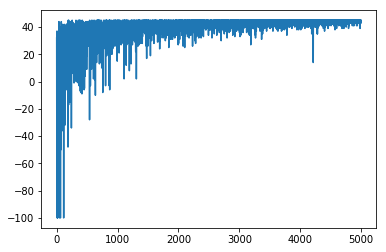

Episode lengths:


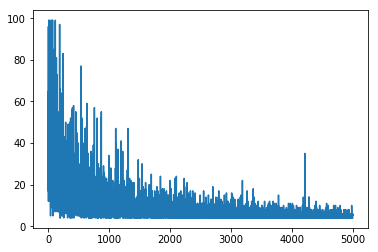

In [19]:
print("Episode rewards:")
plt.plot(stats.episode_rewards)
plt.show()
print("Episode lengths:")
plt.plot(stats.episode_lengths)
plt.show()

In [18]:
import pickle

pickle.dump(stats, open(experiment_dir + "/stats.p", "wb" ))